In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [104]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import optuna

In [105]:
import joblib
import os

# Tratamento dos dados

In [106]:
spotify_youtube_pt1 = pd.read_csv("Dados/spotify_youtube_up_pt1.csv")
spotify_youtube_pt2 = pd.read_csv("Dados/spotify_youtube_up_pt2.csv")

In [107]:
data_extracao = pd.to_datetime("2023-02-07")
spotify_youtube_pt1["upload_date"] = pd.to_datetime(spotify_youtube_pt1["upload_date"])
spotify_youtube_pt1["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt1["upload_date"]).dt.days

spotify_youtube_pt2["upload_date"] = pd.to_datetime(spotify_youtube_pt2["upload_date"])
spotify_youtube_pt2["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt2["upload_date"]).dt.days

In [108]:
spotify_youtube = pd.concat([spotify_youtube_pt1,spotify_youtube_pt2])

In [109]:
spotify_youtube_dummies= pd.get_dummies(spotify_youtube,columns=['Album_type'], dtype=int)

In [110]:
spotify_youtube_dummies['artist_number'] = spotify_youtube_dummies['Artist'].str.split(',').str.len()
spotify_youtube_dummies['engagement_rate'] = spotify_youtube_dummies.apply(lambda row: (row['Likes'] + row['Comments']) / row['Views'] * 100 if row['Views'] > 0 else 0, axis=1)

In [111]:
columns_drop=['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Uri','Url_youtube', 'Title', 'Channel', 'Views', 'Likes','Comments', 'Description', 'Licensed', 'official_video', 'upload_date']
spotify_youtube_df=spotify_youtube_dummies.drop(columns=columns_drop)

In [112]:
spotify_youtube_limpo=spotify_youtube_df.dropna(subset=['Danceability','Energy','Key','Loudness','Speechiness','Acousticness', 'Instrumentalness','Liveness','Valence','Tempo','Duration_ms','Stream','engagement_rate'])

# Preparação dos dados para os experimentos

In [113]:
youtube_30_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<31]
youtube_90_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<91]
youtube_365_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<366]

In [114]:
spotify_youtube_df_366_more = spotify_youtube_limpo.drop(youtube_365_df.index)
spotify_youtube_df_91_365 = youtube_365_df.drop(youtube_90_df.index)
spotify_youtube_df_31_90 = youtube_365_df.drop(youtube_30_df.index)

In [115]:
youtube_30_df=youtube_30_df[youtube_30_df['engagement_rate']<9.338507725109846]
spotify_youtube_df_31_90=spotify_youtube_df_31_90[spotify_youtube_df_31_90['engagement_rate']<4.602401258613792]
spotify_youtube_df_91_365=spotify_youtube_df_91_365[spotify_youtube_df_91_365['engagement_rate']<4.253191569584401]
spotify_youtube_df_366_more=spotify_youtube_df_366_more[spotify_youtube_df_366_more['engagement_rate']<2.251193229196198]

In [116]:
youtube_30_df_x = youtube_30_df.drop('engagement_rate',axis=1)
youtube_30_df_y = youtube_30_df['engagement_rate']

spotify_youtube_df_31_90_x = spotify_youtube_df_31_90.drop('engagement_rate',axis=1)
spotify_youtube_df_31_90_y = spotify_youtube_df_31_90['engagement_rate']

spotify_youtube_df_91_365_x = spotify_youtube_df_91_365.drop('engagement_rate',axis=1)
spotify_youtube_df_91_365_y = spotify_youtube_df_91_365['engagement_rate']

spotify_youtube_df_366_more_x = spotify_youtube_df_366_more.drop('engagement_rate',axis=1)
spotify_youtube_df_366_more_y = spotify_youtube_df_366_more['engagement_rate']

In [117]:
spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=44)
spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=44)

In [118]:
#spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=42)
spotify_youtube_df_31_90X_train, spotify_youtube_df_31_90X_test, spotify_youtube_df_31_90y_train, spotify_youtube_df_31_90y_test = train_test_split(spotify_youtube_df_31_90_x, spotify_youtube_df_31_90_y, test_size=0.25, random_state=42)
spotify_youtube_df_91_365X_train, spotify_youtube_df_91_365X_test, spotify_youtube_df_91_365y_train, spotify_youtube_df_91_365y_test = train_test_split(spotify_youtube_df_91_365_x, spotify_youtube_df_91_365_y, test_size=0.25, random_state=42)
#spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=42)

In [119]:
# Dados de treino 
sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train,spotify_youtube_df_366_more_x])
sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train,spotify_youtube_df_366_more_y])

# Normalização do treino
scaler_all = MinMaxScaler()
sy_x_train_scaled = scaler_all.fit_transform(sy_x_train)

In [120]:
# Normalização do treino de 30 dias
sy_30_x_train_scaled = scaler_all.transform(spotify_youtube_30X_train)

In [121]:
# Dados para treinar o modelo com dados de 0 a 90 dias
sy_90_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train])
sy_90_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train])

# Normalização do treino de 90 dias
sy_90_x_train_scaled = scaler_all.transform(sy_90_x_train)

In [122]:
# Dados para treinar o modelo com dados de 0 a 365 dias
sy_365_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train])
sy_365_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train])

# Normalização do treino de 90 dias
sy_365_x_train_scaled = scaler_all.transform(sy_365_x_train)

In [123]:
# Para testar o desempenho do modelo com videos com ate 30 dias
sy_30_x_test=spotify_youtube_30X_test
sy_30_y_test=spotify_youtube_30y_test

# validação de 30 dias
sy_30_x_val=spotify_youtube_30X_val
sy_30_y_val=spotify_youtube_30y_val

# Para testar o desempenho do modelo com videos com ate 90 dias
sy_90_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test])
sy_90_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test])

# Para testar o desempenho do modelo com videos com ate 1 ano
sy_365_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test,spotify_youtube_df_91_365X_test])
sy_365_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test,spotify_youtube_df_91_365y_test])

In [124]:
# Normalizção dos dados de teste de 30 dias
sy_30_x_test_scaled = scaler_all.transform(sy_30_x_test)

# Normalizção dos dados de teste de 90 dias
sy_90_x_test_scaled = scaler_all.transform(sy_90_x_test)

# Normalizção dos dados de teste de 365 dias
sy_365_x_test_scaled = scaler_all.transform(sy_365_x_test)

# Normalização dos dados de validação de 30 dias
sy_30_x_val_scaled = scaler_all.transform(sy_30_x_val)

# Experimento

In [125]:
caminho_modelos = "Modelos/best_xgb_model_grid.pkl"
if os.path.exists(caminho_modelos):
    modelo_xgb = joblib.load(caminho_modelos)

In [59]:
predicoes_30 = modelo_xgb.predict(sy_30_x_test_scaled)


In [62]:
linha_especifica = sy_30_x_test_scaled[0]  # Substitua 0 pelo índice da linha desejada
print(linha_especifica)

[8.31794872e-01 7.27994478e-01 1.00000000e+00 8.69093299e-01
 3.34719335e-02 3.61435041e-02 3.29000000e-06 6.25064149e-02
 5.37840565e-01 4.63768577e-01 3.12998709e-02 7.94527714e-04
 3.14465409e-03 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


In [81]:
# Seleciona a linha específica (substitua 0 pelo índice desejado)
linha_especifica = sy_30_x_test_scaled[0].reshape(1, -1)  # Reshape para manter o formato esperado pelo modelo

# Faz a previsão para a linha selecionada
predicao_linha = modelo_xgb.predict(linha_especifica)

# Exibe o resultado da previsão
print(f"Previsão para a linha selecionada: {predicao_linha}")

Previsão para a linha selecionada: [2.565672]


In [193]:
# Localiza a linha original no DataFrame antes da normalização
indice_linha = 4
linha_original = sy_30_x_test.iloc[indice_linha].copy()
linhas=[]
dias=[7,14,21,28,35,42,49,56,63,70,77,84,91]
for day in dias:
    # Altera o valor da coluna 'dias_na_plataforma'
    novo_valor_dias = day  # Substitua pelo novo valor desejado
    linha_original['dias_na_plataforma'] = novo_valor_dias

    # Adiciona a linha alterada à lista
    linhas.append(linha_original.copy())


linhas_df = pd.DataFrame(linhas, columns=sy_30_x_test.columns)

# Normaliza a linha alterada
linha_normalizada = scaler_all.transform(linhas_df)

# Faz a previsão para a linha alterada
predicao_linha_alterada = modelo_xgb.predict(linha_normalizada)

# Exibe o resultado da previsão
print(f"Previsão para a linha alterada: {predicao_linha_alterada}")

Previsão para a linha alterada: [4.3426538 3.5441756 3.631095  3.070981  2.417306  2.417306  2.27854
 2.265109  2.265109  2.2524772 2.2524772 2.2524772 2.2524772]


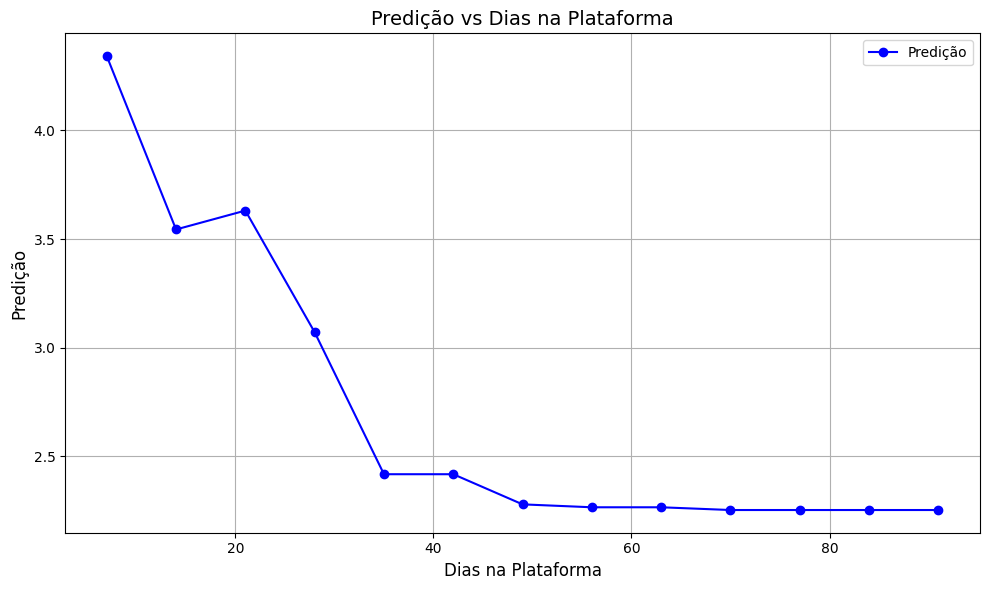

In [194]:
# Supondo que predicao_linha_alterada contém as previsões para diferentes valores de 'dias_na_plataforma'
# Dias correspondentes às previsões

# Criação do gráfico de linhas
plt.figure(figsize=(10, 6))
plt.plot(dias, predicao_linha_alterada, marker='o', linestyle='-', color='b', label='Predição')

# Configurações do gráfico
plt.title('Predição vs Dias na Plataforma', fontsize=14)
plt.xlabel('Dias na Plataforma', fontsize=12)
plt.ylabel('Predição', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Exibe o gráfico
plt.show()

In [216]:
class EngajamentPredictor:
    def __init__(self, model_name, scaler):
        self.model = self.select_model(model_name)
        self.scaler = scaler

    def select_model(self, model_name):
        if model_name == 'linear_regression':
            return joblib.load("Modelos/best_Linear_Regressor_model_grid.pkl")
        elif model_name == 'random_forest':
            return joblib.load("Modelos/best_rf_model_grid.pkl")
        elif model_name == 'mlp':
            return joblib.load("Modelos/best_mlp_model_grid.pkl")
        elif model_name == 'xgboost':
            return joblib.load("Modelos/best_xgb_model_grid.pkl")
        else:
            raise ValueError("Modelo não suportado. Escolha entre 'linear_regression', 'random_forest', 'mlp' ou 'xgboost'.")
        
    def predict(self, data, numeros_semanas):
        dias = [i for i in range(7, 7 * numeros_semanas + 1, 7)]  # Gera uma lista de dias com base no número de semanas
        dias_prev=[]
        for day in dias:
            # Altera o valor da coluna 'dias_na_plataforma'
            novo_valor_dias = day  # Substitua pelo novo valor desejado
            data['dias_na_plataforma'] = novo_valor_dias

            # Adiciona a linha alterada à lista
            dias_prev.append(data.copy())
        
        dias_df = pd.DataFrame(dias_prev, columns=sy_30_x_test.columns)

        # Normaliza os dados de entrada
        data_scaled = self.scaler.transform(dias_df)
        # Faz a previsão usando o modelo
        predictions = self.model.predict(data_scaled)
        #print(f"Previsão para a linha alterada: {predictions}")

        # Exibe o resultado da previsão
        self.plot_predictions(dias, predictions)
        return predictions
    
    def plot_predictions(self, dias, predictions):
        # Converte os dias para semanas
        semanas = [dia // 7 for dia in dias]

        # Criação do gráfico de linhas
        plt.figure(figsize=(10, 6))
        plt.plot(semanas, predictions, marker='o', linestyle='-', color='b', label='Predição')

        # Configurações do gráfico
        plt.title('Engajamento Semanal Previsto', fontsize=14)
        plt.xlabel('Semanas na Plataforma', fontsize=12)
        plt.ylabel('Predição', fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        # Exibe o gráfico
        plt.show()

In [215]:
numeros_semanas=12
dias=[i for i in range(7, 7 * numeros_semanas + 1, 7)]
[dia // 7 for dia in dias]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

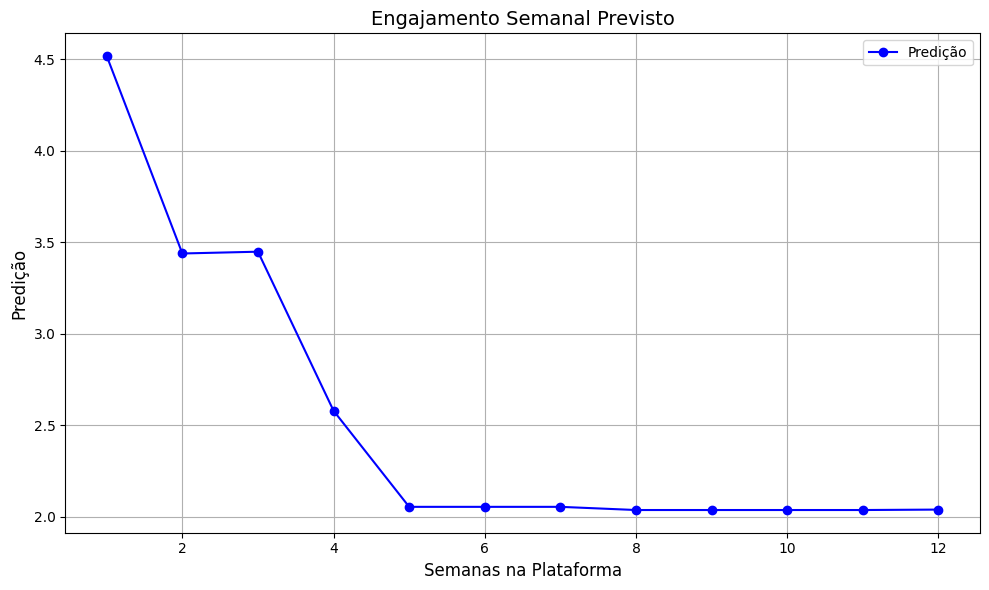

In [217]:
ep=EngajamentPredictor(model_name='xgboost', scaler=scaler_all)
predictions = ep.predict(data=sy_30_x_test.iloc[0].copy(), numeros_semanas=12)
